In [ ]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from dotenv import load_dotenv


In [ ]:
load_dotenv()

In [ ]:
input_file_path = "../data/raw/steam_data.csv"
output_file_path = "../data/processed/steam_data.csv"

In [ ]:
def clean_price(price):
    if isinstance(price, str):
        price = price.lower()
        if "free" in price:
            return "free"

        match = re.search(r"\$\d+(\.\d{2})?", price)
        if match:
            try:
                return f"${float(match.group()[1:]):.2f}"
            except ValueError:
                return np.nan
    return np.nan


def process_and_save_data(file_path, output_path):
    steam_data = pd.read_csv(file_path)
    filtered_data = steam_data[
        [
            "name",
            "categories",
            "user_reviews",
            "date",
            "developer",
            "publisher",
            "price",
        ]
    ]

    filtered_data["price"] = filtered_data["price"].apply(clean_price)
    filtered_data.dropna(subset=["name", "price", "categories", "user_reviews", "date", "developer", "publisher"], inplace=True)
    sampled_data = filtered_data.copy()#.sample(n=10000, random_state=42)
    sampled_data["combined_text"] = (
        sampled_data["name"]
        + " "
        + sampled_data["categories"]
        + " "
        + sampled_data["user_reviews"].astype(str)
        + " "
        + sampled_data["date"]
        + " "
        + sampled_data["developer"]
        + " "
        + sampled_data["publisher"]
    )

    sampled_data.to_csv(output_path, index=False)

In [99]:
process_and_save_data(input_file_path, output_file_path)

/tmp/ipykernel_2717555/1139591644.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["price"] = filtered_data["price"].apply(clean_price)
/tmp/ipykernel_2717555/1139591644.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.dropna(subset=["name", "price", "categories", "user_reviews", "date", "developer", "publisher"], inplace=True)


In [100]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [101]:
device = torch.device(
            "cuda"
            if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available() else "cpu"
        )
print(f"Using device: {device}")

Using device: cuda


In [102]:
data = pd.read_csv(output_file_path)
train_data, val_data = train_test_split(data, test_size=0.1, random_state=42)

In [103]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt"
        )
        return inputs.input_ids.squeeze(0), inputs.attention_mask.squeeze(0)


In [104]:
base_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = base_model.encode(data['combined_text'].tolist(), convert_to_tensor=True)

In [105]:
train_embeddings, val_embeddings = train_test_split(embeddings, test_size=0.2, random_state=42)
train_data = TensorDataset(train_embeddings)
train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
val_data = TensorDataset(val_embeddings)
val_loader = DataLoader(val_data, batch_size=512, shuffle=True)

In [106]:
class EmbeddingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=128):
        super(EmbeddingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [ ]:
input_dim = embeddings.shape[1]
autoencoder = EmbeddingAutoencoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = batch[0].to(device)
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)

        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.0010
Epoch [2/10], Loss: 0.0007
Epoch [3/10], Loss: 0.0006
Epoch [4/10], Loss: 0.0005
Epoch [5/10], Loss: 0.0004
Epoch [6/10], Loss: 0.0004
Epoch [7/10], Loss: 0.0004
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0003
Epoch [10/10], Loss: 0.0003


In [ ]:
torch.save(autoencoder.state_dict(), f'../{os.getenv("EMBEDDING_MODEL_PATH")}')
optimized_embeddings = autoencoder.encoder(embeddings).cpu().detach().numpy()

In [ ]:
tsne_original = TSNE(n_components=2, random_state=42, perplexity=40)
original_2d = tsne_original.fit_transform(embeddings.cpu().numpy())

tsne_optimized = TSNE(n_components=2, random_state=42, perplexity=40)
optimized_2d = tsne_optimized.fit_transform(optimized_embeddings)


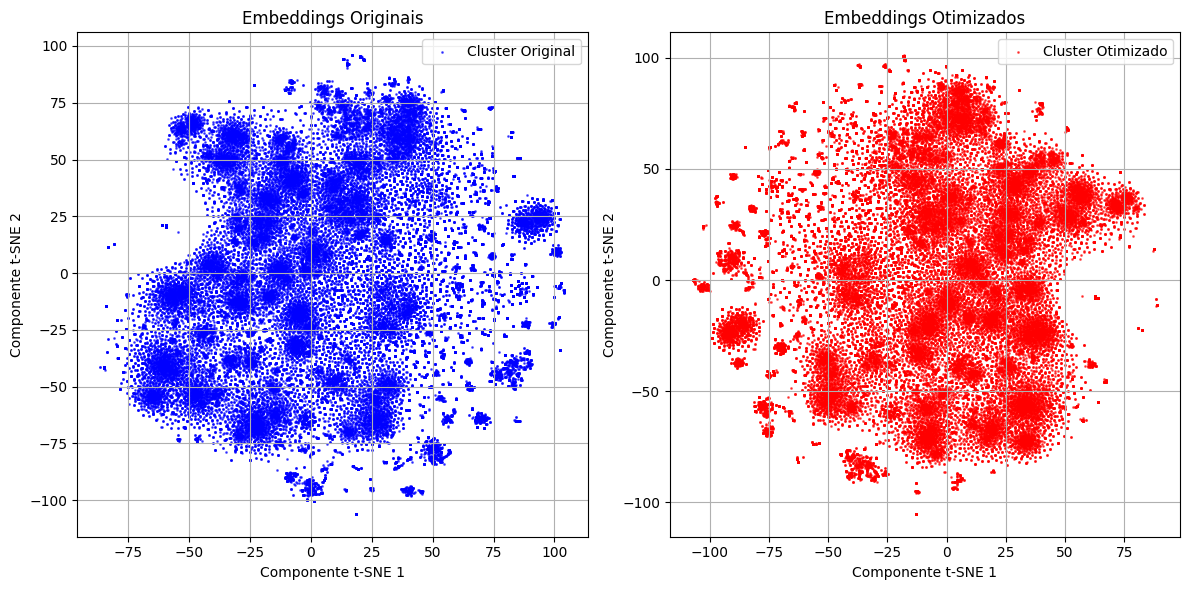

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(original_2d[:, 0], original_2d[:, 1], s=1, alpha=0.6, c='blue', label='Original Cluster')
plt.title("Original Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)
plt.savefig("../images/detailed_original_embeddings.png")

plt.subplot(1, 2, 2)
plt.scatter(optimized_2d[:, 0], optimized_2d[:, 1], s=1, alpha=0.6, c='red', label='Optimized Cluster')
plt.title("Optimized Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)
plt.savefig("../images/detailed_optimized_embeddings.png")

plt.tight_layout()
plt.show()
